# Overview

The purpose of this analysis is to identify opportunities and generate recommendations for Microsoft in anticipation of their new film production company. 

Since Microsoft has no prior experience in film production this analysis serves to create a strategy for success utilizing market data. To gain this insight we will use data from [IMDB](https://www.imdb.com), and [The Numbers](https://www.the-numbers.com/) to find trends in genre, finance, and talent. 

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4b/Microsoft_Studios_logo.svg">

## Data Used
Data used for this project was sourced from [IMDB](https://www.imdb.com), and [The Numbers](https://www.the-numbers.com/). 

- IMDB contains decriptive information about thousands of movies. Such as year released, genre, ratings, and title. IMDB also contains decriptive information about thousands of people in the film industry. 
- The Numbers contains financial data of movies sorted by title, release date, and insights on budget and gross earnings. 

By combining the IMDB movie data, talent data, and The Numbers financial data we will be able to ascertain trends in the film industry. 

## Data Preparation 

### Clean and merge multiple dataframes to prodce a single comprehensive dataframe that will contain all necessary information for analysis.  

#### 1. Import

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import data from csv
talent = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
movie_info = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
movie_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
finance = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#### 2. Begin process to combine dataframe
 - Merge IMDB film data with rating data by `tconst`

In [3]:
#merge movie_info and movie_ratings
movies = movie_info.set_index('tconst').join(movie_ratings.set_index('tconst'))
movies = movies.reset_index()

movies['merge_id'] = movies['start_year'].astype(str) + movies['primary_title']

movies.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)


- Clean The Numbers data in preparation for merging with IMDB data

In [4]:
#year as an integer
finance['release_date'] = pd.to_datetime(finance['release_date'])
finance['release_date'] = pd.DatetimeIndex(finance['release_date']).year 

#convert money from string to integers
finance['production_budget'] = finance['production_budget'].str\
                               .replace(",","")
finance['production_budget'] = finance['production_budget'].str\
                               .replace("$","")
finance['production_budget'] = finance['production_budget'].astype(int)


finance['domestic_gross'] = finance['domestic_gross'].str\
                               .replace(",","")
finance['domestic_gross'] = finance['domestic_gross'].str\
                               .replace("$","")
finance['domestic_gross'] = finance['domestic_gross'].astype(int)

finance.drop(columns = ['id'], inplace = True)

- Create columns to calculate KPI indicators for relevant financial insights

In [5]:
#calculate ROI and create ROI column 
finance['roi'] = finance['domestic_gross'] / finance['production_budget']

To merge IMDB and The Numbers dataframe require the creation of a common key. The data sets shared information about movie titles and years produced. Therefore, conentate year and movie title to create the common key. In the code below this is known as the `merge_id`.

In [6]:
#create common id to merge movie and finance info
finance['merge_id'] = finance['release_date'].astype(str) + finance['movie']

In [7]:
#merge movies and finance dataframes
movies_df = finance.set_index('merge_id').join(movies.set_index('merge_id'))
movies_df = movies_df.reset_index()

In the data each movie is assigned to one or more genres. In order ensure each genre is counted correclty we split it out into individual rows using `.explode()`

In [8]:
#explode genres
movies_df['genres'] = movies_df['genres'].str.split(",")
movies_df = movies_df.explode('genres')

For the purpose of this analysis, we want to only consider films that entered the market and were produced in the past 10 years. 

In [9]:
#drop null values, movies that did not enter the market (0 ROI), movies made in the past 10 years
movies_df = movies_df[movies_df['roi'] !=0]

movies_df = movies_df.dropna(subset = ['genres','averagerating'])

movies_df = movies_df[movies_df['release_date']>2010]

* Merged dataframe

In [10]:
#resulting data frame
movies_df

,merge_id,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi,tconst,primary_title,start_year,genres,averagerating,numvotes
3871,201130 Minutes or Less,2011,30 Minutes or Less,28000000,37053924,"$40,966,716",1.323354,tt1622547,30 Minutes or Less,2011.0,Action,6.1,87254.0
3871,201130 Minutes or Less,2011,30 Minutes or Less,28000000,37053924,"$40,966,716",1.323354,tt1622547,30 Minutes or Less,2011.0,Comedy,6.1,87254.0
3871,201130 Minutes or Less,2011,30 Minutes or Less,28000000,37053924,"$40,966,716",1.323354,tt1622547,30 Minutes or Less,2011.0,Crime,6.1,87254.0
3872,20115 Days of War,2011,5 Days of War,12000000,17479,"$87,793",0.001457,tt1486193,5 Days of War,2011.0,Action,5.6,13089.0
3872,20115 Days of War,2011,5 Days of War,12000000,17479,"$87,793",0.001457,tt1486193,5 Days of War,2011.0,Drama,5.6,13089.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,2019What Men Want,2019,What Men Want,20000000,54611903,"$69,911,903",2.730595,tt7634968,What Men Want,2019.0,Fantasy,4.9,10141.0
5840,2019What Men Want,2019,What Men Want,20000000,54611903,"$69,911,903",2.730595,tt7634968,What Men Want,2019.0,Romance,4.9,10141.0
5841,2019Wonder Park,2019,Wonder Park,100000000,45216793,"$115,149,422",0.452168,tt6428676,Wonder Park,2019.0,Adventure,5.7,3091.0
5841,2019Wonder Park,2019,Wonder Park,100000000,45216793,"$115,149,422",0.452168,tt6428676,Wonder Park,2019.0,Animation,5.7,3091.0


## Analysis 

### Genre
Upon reviw of the `movie_df` we noticed trends can be gleamed by considering a movie's genre. 

Factors for a production studio to consider in film producton are profitiablity (as a measure of ROI), market opportunity, and the critical reception of films.  

In [11]:
genres = movies_df.groupby(by=['genres']).describe()

In [12]:
roi = genres['roi'].sort_values(by='count', ascending = False)

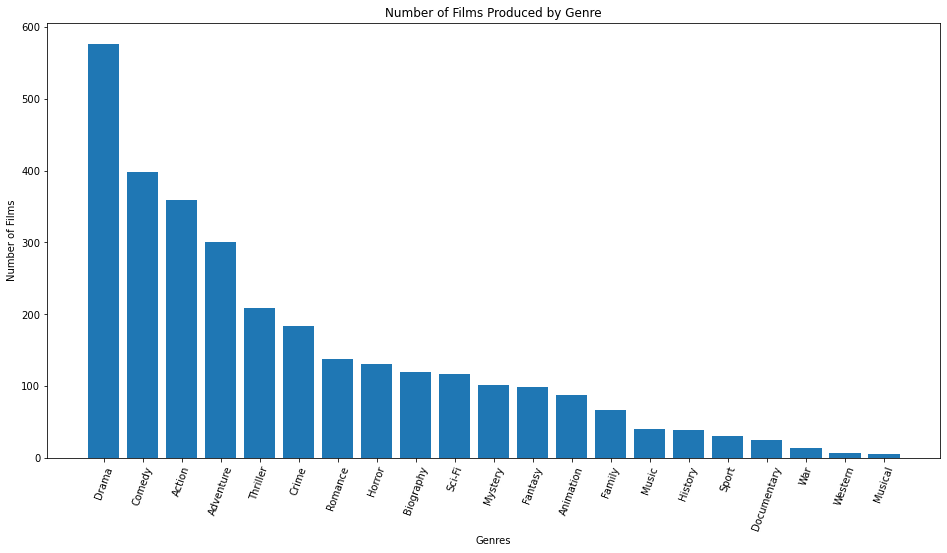

In [13]:
#Graph the number of films produced by genre
fig, ax = plt.subplots(figsize = (16, 8))

x = list(roi.index)
y = list(roi['count'])

plt.bar(x, y)
ax.set_xlabel('Genres')
ax.set_ylabel('Number of Films')
ax.set_title('Number of Films Produced by Genre')
plt.xticks(rotation = 70)
plt.show()

In [14]:
#Graph ROI by genre
roi = roi.sort_values(by='50%', ascending = False)

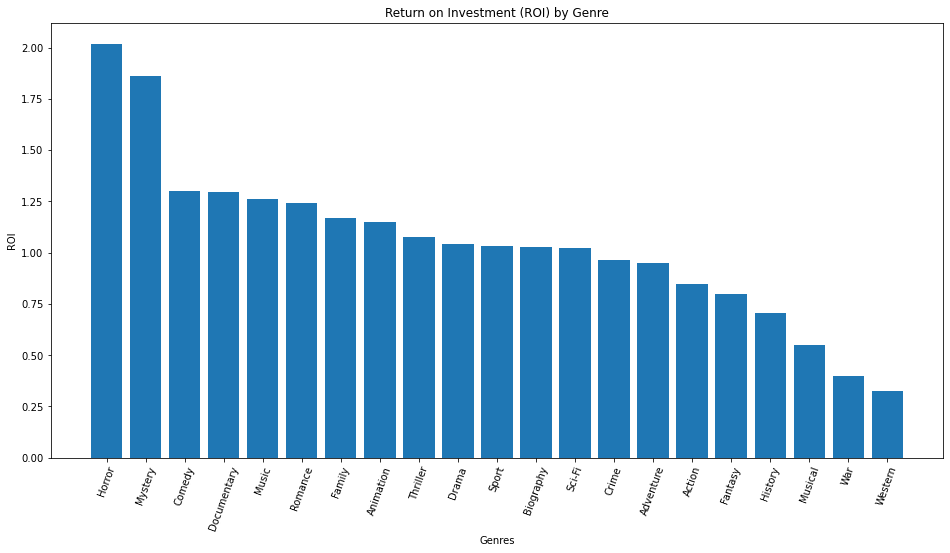

In [15]:
#Graph genre by ROI [median]
fig, ax = plt.subplots(figsize = (16, 8))

x = list(roi.index)
y = list(roi['50%'])

plt.bar(x, y)
ax.set_xlabel('Genres')
ax.set_ylabel('ROI')
ax.set_title('Return on Investment (ROI) by Genre')
plt.xticks(rotation = 70)
plt.show()

In [16]:
ratings = genres['averagerating'].sort_values(by='mean', ascending = False)

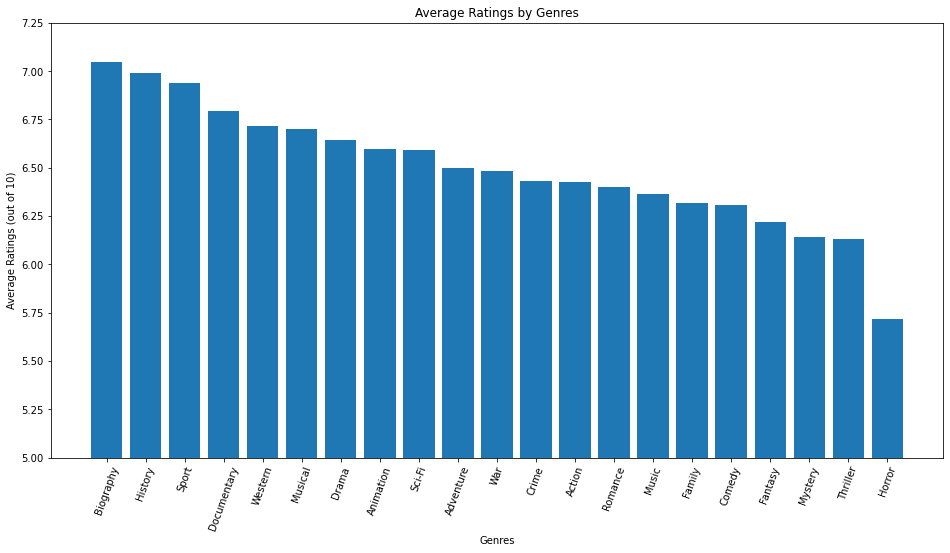

In [17]:
#Graph rating by genre
fig, ax = plt.subplots(figsize = (16, 8))

x = list(ratings.index)
y = list(ratings['mean'])

plt.bar(x, y)
ax.set_xlabel('Genres')
ax.set_ylabel('Average Ratings (out of 10)')
ax.set_title('Average Ratings by Genres')
plt.ylim(5, 7.25)
plt.xticks(rotation = 70)
plt.show()

By splitting out and grouping by genre we were able see how many films are produced of a certain genre, the relative profitability (based on ROI), and the average ratings by genre. 

Given these insights we would recommend Microsoft produce Documentaries based on the following: 
- the market opportunity: few other studios are producing documentaries
- the high ROI
- the high average ratings

### Budget

A production studio should consider the financial implications of producing a film. A film could have high earnings at the box office, but given the production costs of a film, the overall project would not be profitable. Therefore we calculated ROI (the ratio of earnings to investments). 

Given our recommendation to produce Documentaries we analyzed the fiancial data with the genre of Documentaries in mind. 

In [18]:
#relationship between metrics
movies_df.corr()

,release_date,production_budget,domestic_gross,roi,start_year,averagerating,numvotes
release_date,1.000000,0.053745,0.085714,0.026029,1.000000,-0.009073,-0.148538
production_budget,0.053745,1.000000,0.690620,-0.092511,0.053745,0.195878,0.534730
domestic_gross,0.085714,0.690620,1.000000,0.044731,0.085714,0.326357,0.659750
roi,0.026029,-0.092511,0.044731,1.000000,0.026029,-0.040787,0.014913
start_year,1.000000,0.053745,0.085714,0.026029,1.000000,-0.009073,-0.148538
averagerating,-0.009073,0.195878,0.326357,-0.040787,-0.009073,1.000000,0.514689
numvotes,-0.148538,0.534730,0.659750,0.014913,-0.148538,0.514689,1.000000


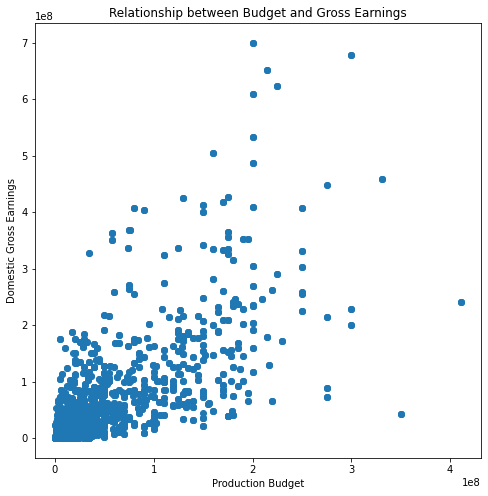

In [19]:
#Graph rating by genre
fig, ax = plt.subplots(figsize = (8, 8))

x = movies_df['production_budget']
y = movies_df['domestic_gross']

ax.scatter(x, y)
ax.set_xlabel('Production Budget')
ax.set_ylabel('Domestic Gross Earnings')
ax.set_title('Relationship between Budget and Gross Earnings')
plt.show()

In [20]:
#comparison of genres by budget
genre_budget = genres['production_budget']
genre_budget = genre_budget['mean'].sort_values(ascending = False)

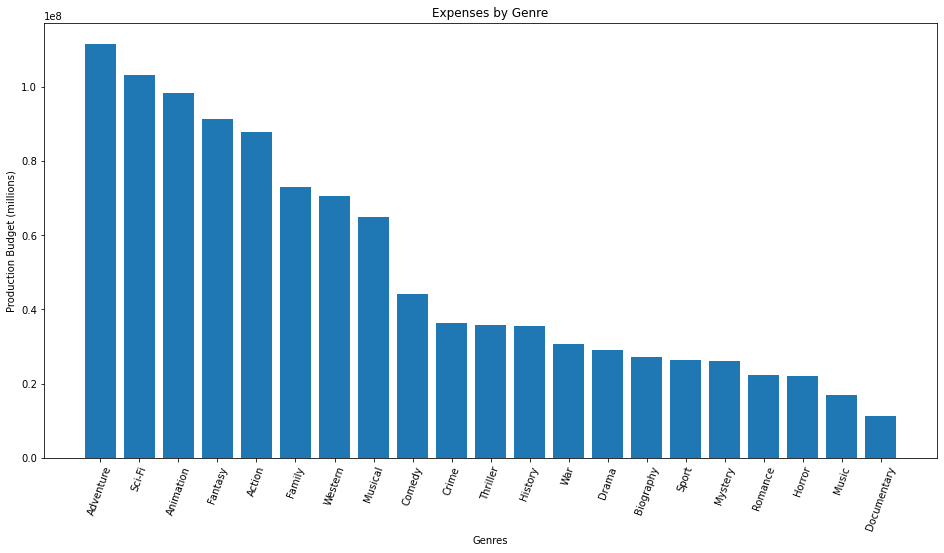

In [21]:
#Graph budget by genre
fig, ax = plt.subplots(figsize = (16, 8))

x = list(genre_budget.index)
y = list(genre_budget)

plt.bar(x, height = y)
ax.set_xlabel('Genres')
ax.set_ylabel('Production Budget (millions)')
ax.set_title('Expenses by Genre')
plt.xticks(rotation = 70)
plt.show()

In [22]:
#Median Production Budget 2750000
movies_df[movies_df['genres']=='Documentary'].mean()

release_date         2.013708e+03
production_budget    1.133271e+07
domestic_gross       1.303669e+07
roi                  2.314607e+00
start_year           2.013708e+03
averagerating        6.791667e+00
numvotes             5.908125e+03
dtype: float64

The relationship between production budget and earnings and the low cost of producing a Documentary Microsoft should establish an initial budget of $2,750,000 for their films. 

## Talent

The final factor to consider is human captial: who should make the films. Since Documentaries are a niche genre the decision to hire a director who specializes in this genre is critial. 

IMDB provides information about individuals in the film industry. For this analysis we considered filmakers who have previously worked on Documentaries within the past 10 years. 

In [23]:
#drop rows that did not include professions or title
talent = talent.dropna(subset=['primary_profession', 'known_for_titles'])

In [24]:
#Explode professions and known films
talent['primary_profession']=talent['primary_profession'].str.split(",")
talent['known_for_titles']=talent['known_for_titles'].str.split(",")

In [25]:
talent = talent.explode('primary_profession')

In [26]:
talent = talent.explode('known_for_titles')

In [27]:
#Join movie dataframe with the talent dataframe
talent = talent.set_index('known_for_titles').join(movies_df.set_index('tconst'))
talent = talent.reset_index()

In [28]:
#clean table by dropping null values from metrics needed for analysis
talent = talent.dropna(subset=['roi', 'genres', 'averagerating','primary_profession'])

In [29]:
talent = talent.drop(columns = ['birth_year', 'death_year',
       'merge_id', 'release_date', 'movie',
       'worldwide_gross', 'start_year', 'numvotes'])

In [30]:
doc_directors = talent[(talent['genres']=='Documentary') & \
                       (talent['primary_profession']=='director')]\
                       .sort_values(by='roi', ascending=False)
doc_directors

,index,nconst,primary_name,primary_profession,production_budget,domestic_gross,roi,primary_title,genres,averagerating
1206025,tt1702443,nm0160840,Jon M. Chu,director,13000000.0,73013910.0,5.616455,Justin Bieber: Never Say Never,Documentary,1.6
1206035,tt1702443,nm3708437,Sebastian Podesta,director,13000000.0,73013910.0,5.616455,Justin Bieber: Never Say Never,Documentary,1.6
1274564,tt1781784,nm0701245,Tom Putnam,director,225000.0,1109276.0,4.930116,Burn,Documentary,7.5
1274569,tt1781784,nm2198644,Brenna Sanchez,director,225000.0,1109276.0,4.930116,Burn,Documentary,7.5
1274573,tt1781784,nm1890918,Mark Eaton,director,225000.0,1109276.0,4.930116,Burn,Documentary,7.5
1938928,tt2926868,nm4991030,Reber Dosky,director,12800000.0,51872378.0,4.052530,The Call,Documentary,7.9
3010890,tt6184774,nm3901669,Van Royko,director,3000000.0,7233471.0,2.411157,Let There Be Light,Documentary,6.7
3010888,tt6184774,nm1117383,Mila Aung-Thwin,director,3000000.0,7233471.0,2.411157,Let There Be Light,Documentary,6.7
1424967,tt1976608,nm0233771,Joseph Dorman,director,500000.0,1131261.0,2.262522,Sholem Aleichem: Laughing in the Darkness,Documentary,6.8
1595803,tt2215719,nm5061089,Edward Lovelace,director,12000000.0,25326071.0,2.110506,Katy Perry: Part of Me,Documentary,5.9


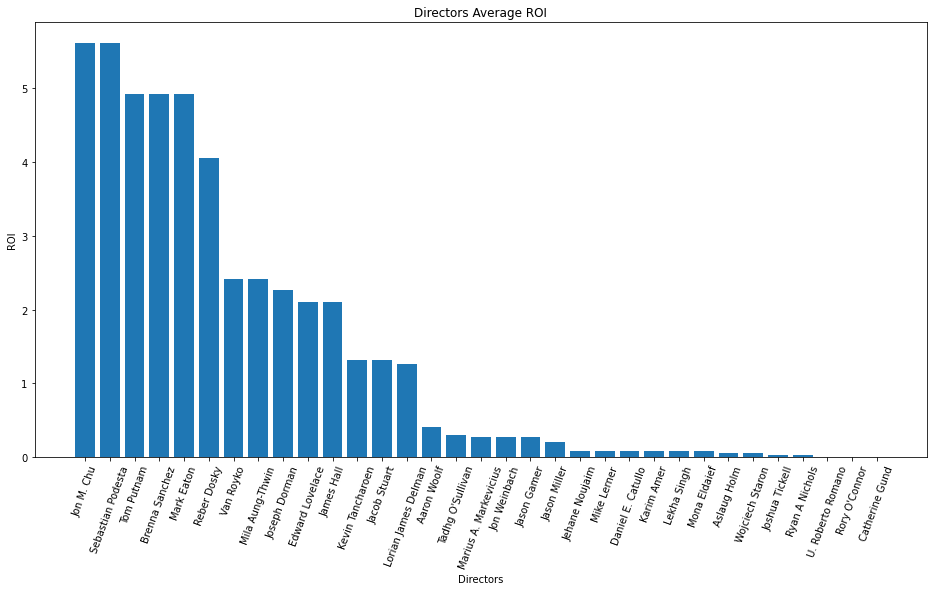

In [31]:
#Graph rating by genre
fig, ax = plt.subplots(figsize = (16, 8))

x = list(doc_directors['primary_name'])
y = list(doc_directors['roi'])

plt.bar(x, y)
ax.set_xlabel('Directors')
ax.set_ylabel('ROI')
ax.set_title('Directors Average ROI')
plt.xticks(rotation = 70)
plt.show()

The above listed directors have a track record of working on Documentaries. However, hiring pratices should consider a variety of factors not demonstrated in this analysis. 

# Conclusion

After analysis of IMDB movie data and The Numbers financial data recommend Microsoft Studios: 
- Create documentaries
- Establish an initial production budget of $2.75 million
- Hire directors with a proven ROI

These recommendations will create a blueprint for succes for Microsoft. 